## Get the query results of "fmri & love" from PubMed:

In [106]:
from pathlib import Path
import requests

URL = "https://pubmed.ncbi.nlm.nih.gov/?term=%28%28love%5BTitle%2FAbstract%5D%29+AND+%28fmri%5BTitle%2FAbstract%5D%29%29+AND+%28%22Front+Psychol.%22%5BJournal%5D%29+NOT+%28Editorial%29&filter=datesearch.y_10"

# Set browser-like headers to avoid being blocked by the site
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/125.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://pubmed.ncbi.nlm.nih.gov/",
}

outfile = Path(
    f"front_psychol_fmri_love.html"
)

with requests.Session() as s:
    s.headers.update(headers)
    resp = s.get(URL, timeout=30)
    resp.raise_for_status()           # raise an error for non-200 responses
    # Use server-provided encoding when available; default to utf-8
    if not resp.encoding:
        resp.encoding = "utf-8"
    outfile.write_text(resp.text, encoding=resp.encoding)

print(f"Saved {outfile.resolve()} ({outfile.stat().st_size:,} bytes)")


Saved /Users/svjjsjrjs/github-classroom/ntu-info/neurosynth-etl-shih-yunLin/front_psychol_fmri_love.html (239,633 bytes)


filter the paper 
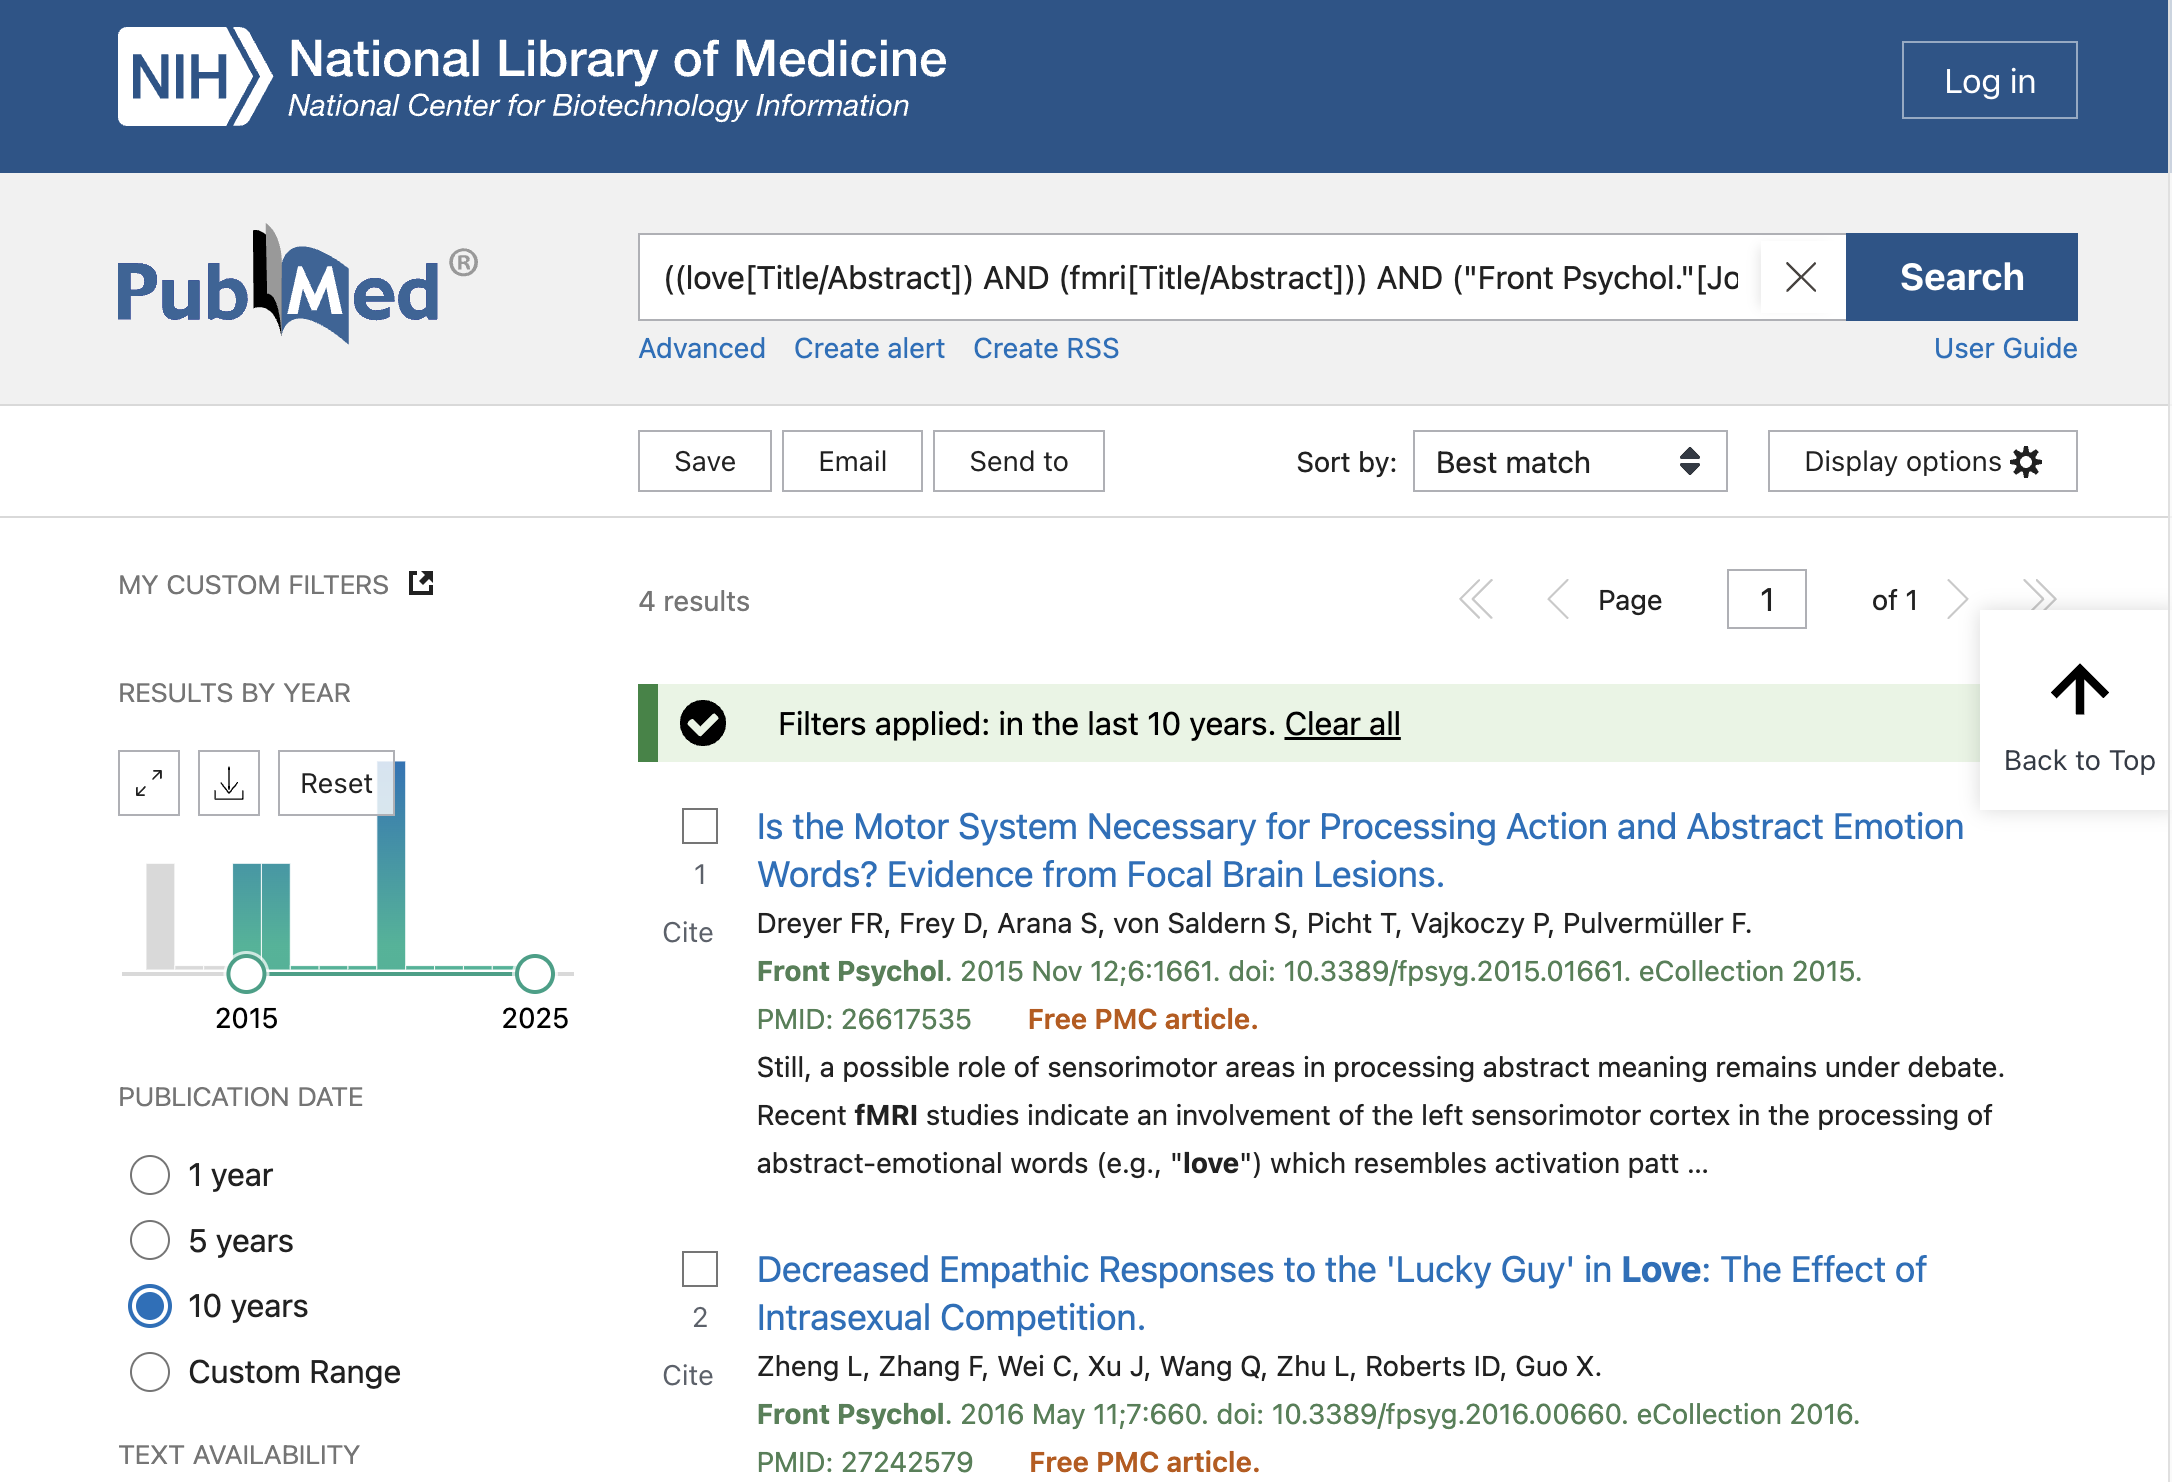

# Extract PMIDs from a PubMed HTML page
Here we use **BeautifulSoup** and **regular expressions** to extract PMIDs from a saved PubMed HTML page.

In [107]:
from bs4 import BeautifulSoup
import re
from pathlib import Path
import pandas as pd

HTML_PATH = Path('front_psychol_fmri_love.html')  # change this if needed
html_text = HTML_PATH.read_text(encoding='utf-8', errors='ignore')

In [108]:
soup = BeautifulSoup(html_text, 'html.parser')
meta = soup.find('meta', attrs={'name': 'log_displayeduids'})
pmids_str=meta.get('content')
print(pmids_str)
pmids= re.findall(r'\d+', pmids_str)
# or simply pmids=pmids_str.split(',')
print(pmids)

32457675,32528365,27242579
['32457675', '32528365', '27242579']


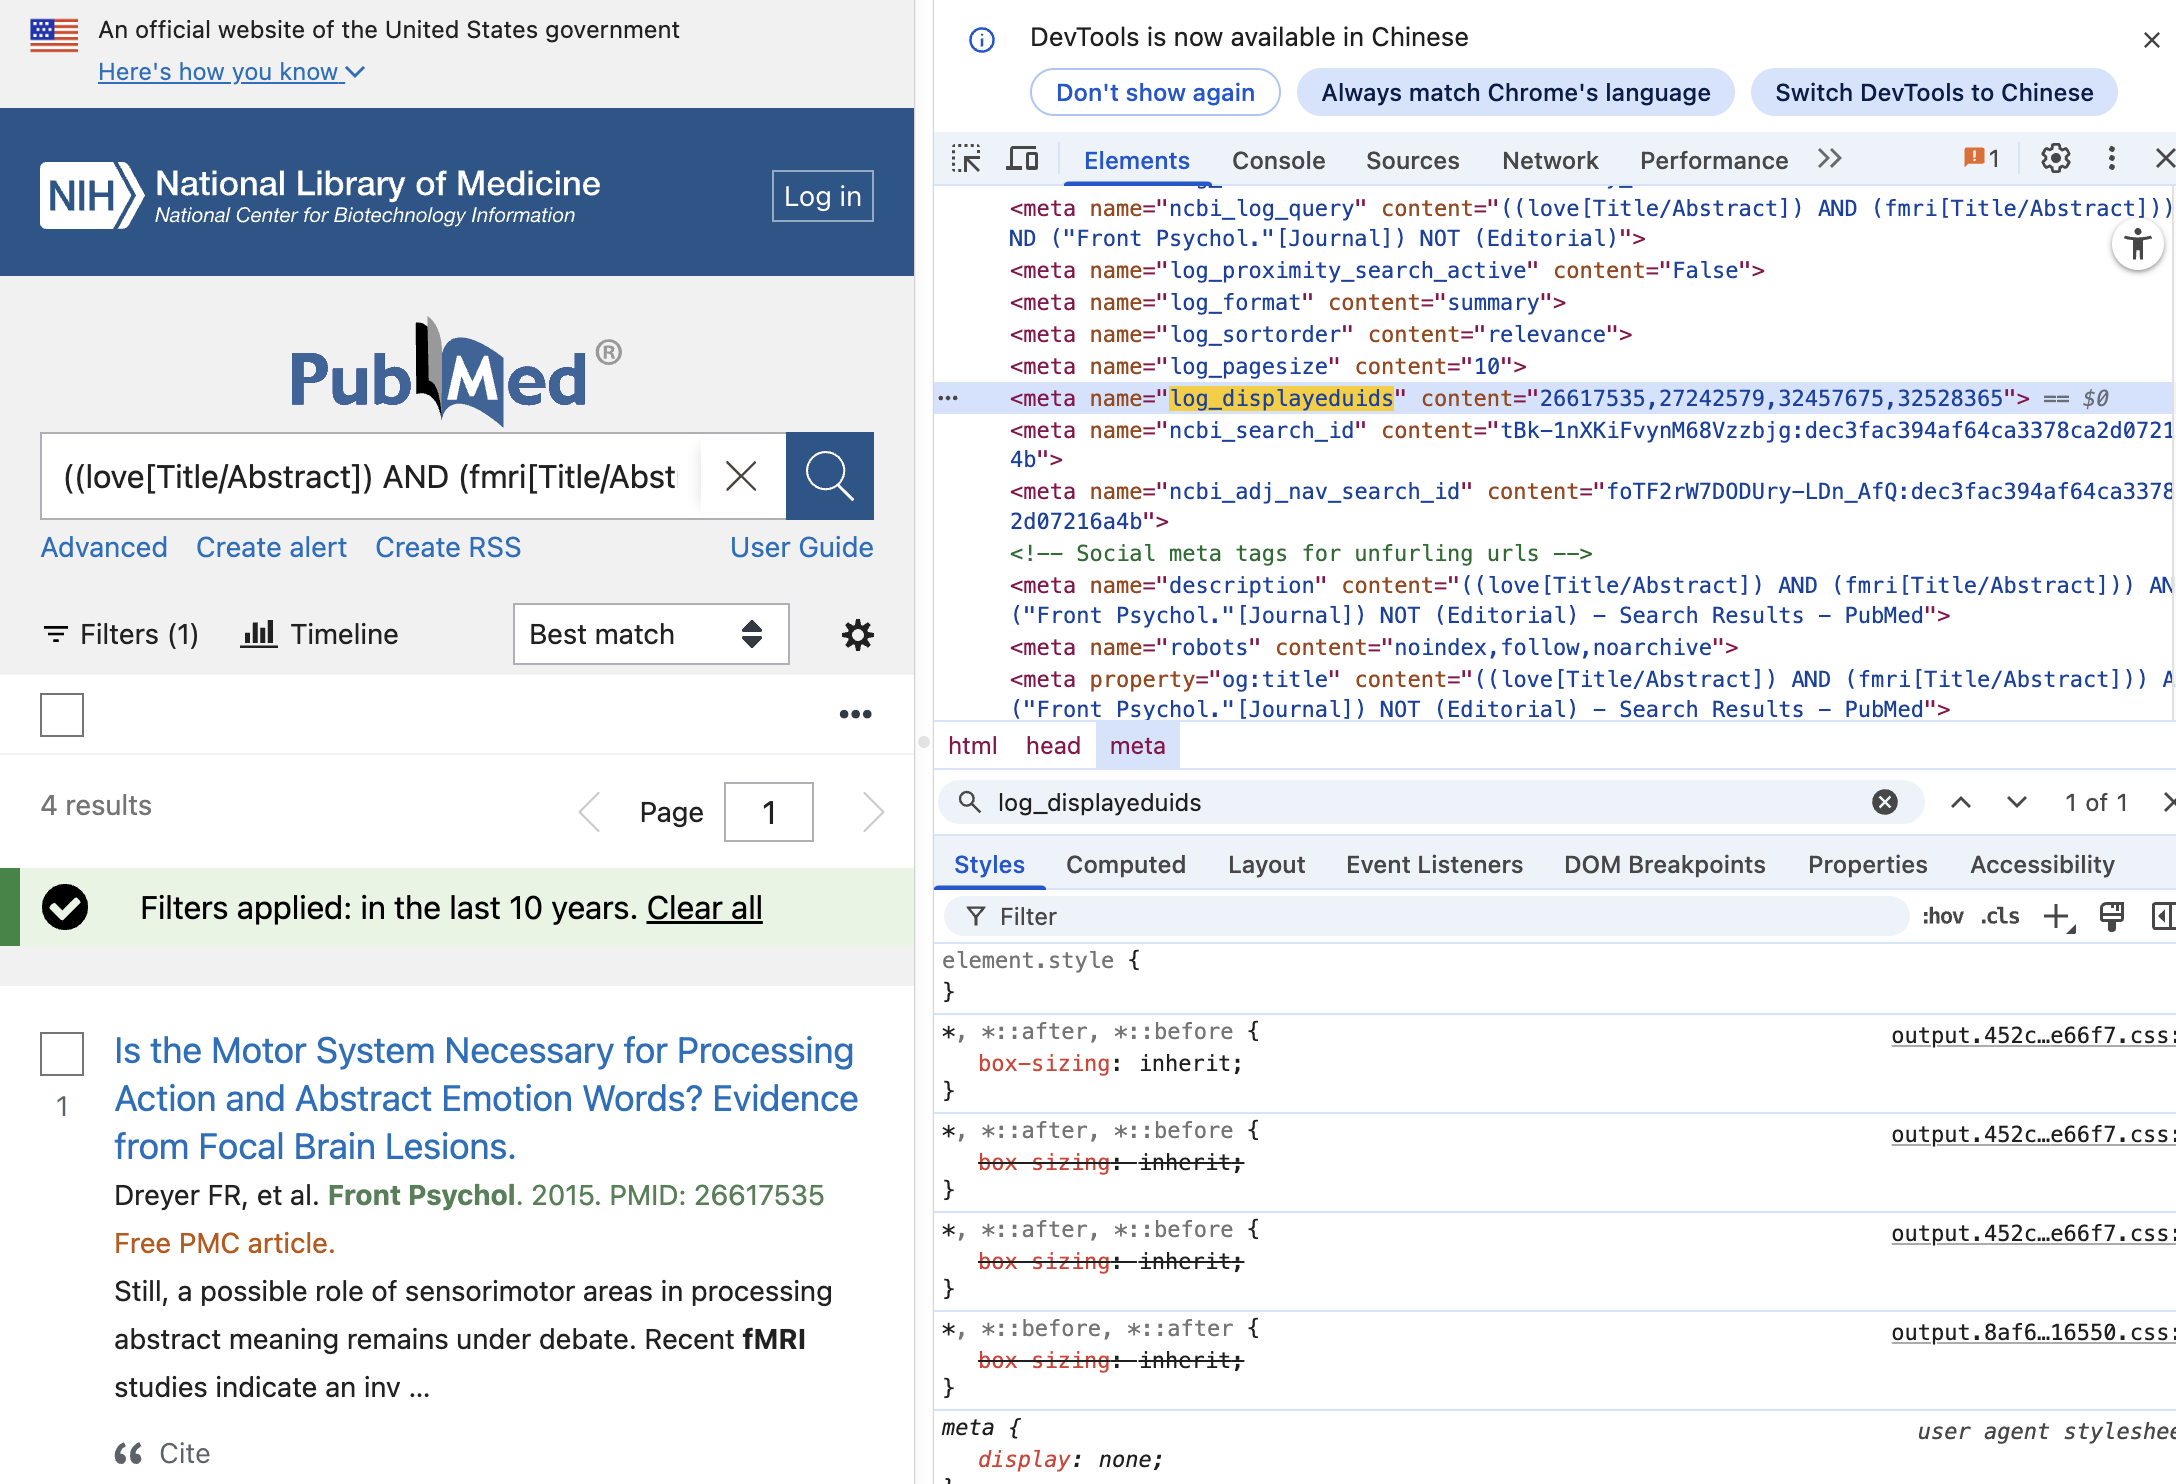

# Test LM Studio API

In [109]:
# See all the available models:
import json

url = "http://localhost:1234/v1/models"
response = requests.get(url)
models = response.json()
print(json.dumps(models, indent=4))

{
    "data": [
        {
            "id": "gemma-3-4b-it-qat",
            "object": "model",
            "owned_by": "organization_owner"
        },
        {
            "id": "google/gemma-3n-e4b",
            "object": "model",
            "owned_by": "organization_owner"
        },
        {
            "id": "text-embedding-nomic-embed-text-v1.5",
            "object": "model",
            "owned_by": "organization_owner"
        }
    ],
    "object": "list"
}


In [110]:
# Test text -> text:

url = "http://localhost:1234/v1/chat/completions"

payload = {
    "model": "gemma-3-4b-it-qat",
    "messages": [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "what is 1+1 equals to?"}
    ]
}

response = requests.post(url, json=payload)
data = response.json()
print(data["choices"][0]["message"]["content"])

1 + 1 = 2

Do you want to do some more math problems? 😊


In [111]:
# Test [image, text] -> text:

import base64

with open("32528365_Table3.jpg", "rb") as f:
    image_base64 = base64.b64encode(f.read()).decode("utf-8")

payload = {
    "model": "gemma-3-4b-it-qat",
    "messages": [
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What's this?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_base64}"
                    }
                }
            ]
        }
    ]
}

response = requests.post(url, json=payload)
data = response.json()
print(data["choices"][0]["message"]["content"])

Okay, let’s break down what this table is showing. It’s from a research study analyzing the effects of different video types on brain activity. Here's a detailed explanation:

**What it is:**

*   **Table 3:** This is simply the title of the table, indicating that it presents significant clusters of activity found during the analysis.
*   **“Significant clusters of activity for the main effects of video type.”**  This tells us the table’s purpose – to identify brain regions showing different activation patterns based on the *type* of video being watched (presumably, there were multiple types of videos).

**Columns Explained:**

*   **Structural location:** This column lists the specific area of the brain where activity was detected. It includes:
    *   Medial frontal pole
    *   Superior temporal gyrus (Sup. temporal gyrus) – this is repeated twice, likely representing two distinct areas within the superior temporal gyrus.
    *   Thalamus
    *   Occipital pole
    *   Putamen
    *

# Write your own [X, Y, Z] coordinate extractor
You can either extract the coordinates from *.html or *.pdf of the 3 target articles:

https://pmc.ncbi.nlm.nih.gov/articles/PMC4863427
https://pmc.ncbi.nlm.nih.gov/articles/PMC7223160
https://pmc.ncbi.nlm.nih.gov/articles/PMC7264388

You can assume you know what tables to extract, IF NEEDED. 

The sprint goal is to generate info_data.csv BY YOURSELF.

In [112]:
import pandas as pd
df = pd.read_csv('info_data.csv')
print(df.head())
print(df['Keywords'][0])

       PMID    PMCID                                           Keywords  \
0  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   
1  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   
2  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   
3  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   
4  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   

   Table   X   Y   Z  
0      2   8  12  58  
1      2 -30  22   4  
2      2  42  10   0  
3      2  -6  14  42  
4      2 -62 -22  34  
pain empathy; intrasexual competition; fMRI; AI; aMCC; MPFC


1. **萃取論文基本資訊**
   - 用 BeautifulSoup 解析 HTML，取得 PMID、PMCID、Keywords。
   - 整理成 DataFrame，顯示前幾筆資料。

In [113]:
from pathlib import Path
import requests
import re

URLS = [
    "https://pmc.ncbi.nlm.nih.gov/articles/PMC4863427/",
    "https://pmc.ncbi.nlm.nih.gov/articles/PMC7223160/",
    "https://pmc.ncbi.nlm.nih.gov/articles/PMC7264388/",
]

headers = {
    "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                   "AppleWebKit/537.36 (KHTML, like Gecko) "
                   "Chrome/125.0.0.0 Safari/537.36"),
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://pmc.ncbi.nlm.nih.gov/",
}

def url_to_filename(url: str) -> str:
    m = re.search(r"(PMC\d+)", url)
    stem = m.group(1) if m else "page"
    return f"{stem}.html"

outdir = Path("pmc_html")
outdir.mkdir(exist_ok=True)

with requests.Session() as s:
    s.headers.update(headers)
    for url in URLS:
        fn = outdir / url_to_filename(url)
        r = s.get(url, timeout=30)
        r.raise_for_status()
        # 確保編碼
        if not r.encoding:
            r.encoding = "utf-8"
        fn.write_text(r.text, encoding=r.encoding)
        print(f"Saved {fn.resolve()} ({fn.stat().st_size:,} bytes)")


Saved /Users/svjjsjrjs/github-classroom/ntu-info/neurosynth-etl-shih-yunLin/pmc_html/PMC4863427.html (177,281 bytes)
Saved /Users/svjjsjrjs/github-classroom/ntu-info/neurosynth-etl-shih-yunLin/pmc_html/PMC7223160.html (353,652 bytes)
Saved /Users/svjjsjrjs/github-classroom/ntu-info/neurosynth-etl-shih-yunLin/pmc_html/PMC7264388.html (202,528 bytes)


In [114]:
from bs4 import BeautifulSoup
import re
from pathlib import Path
import pandas as pd

def extract_meta(html: str):
    soup = BeautifulSoup(html, "html.parser")
    # PMCID
    pmcid = ""
    m = re.search(r"PMCID:\s*(PMC\d+)", html)
    if m:
        pmcid = m.group(1)
    else:
        url_m = re.search(r"(PMC\d+)", html)
        pmcid = url_m.group(1) if url_m else ""
    # PMID
    pmid = ""
    pmid_tag = soup.find("meta", {"name": "citation_pmid"})
    if pmid_tag:
        pmid = pmid_tag.get("content", "")
    else:
        pmid_link = soup.find("a", href=re.compile(r"pubmed\.ncbi\.nlm\.nih\.gov/\d+"))
        if pmid_link:
            pmid = re.search(r"\d+", pmid_link["href"]).group(0)
    # Keywords
    keywords = ""
    kw_section = soup.find("section", class_=re.compile("kwd-group"))
    if kw_section:
        kw_p = kw_section.find("p")
        if kw_p:
            kw_text = kw_p.get_text(" ", strip=True)
            kw_text = re.sub(r"^\s*keywords\s*:?\s*", "", kw_text, flags=re.I)
            parts = [seg.strip(' "\'.,;') for seg in re.split(r"[;,]", kw_text) if seg.strip(' "\'.,;')]
            keywords = "; ".join(parts)
    return pmid, pmcid, keywords

# 批次處理三個檔案，並存進 DataFrame
files = [
    "pmc_html/PMC4863427.html",
    "pmc_html/PMC7223160.html",
    "pmc_html/PMC7264388.html"
]
meta_rows = []
for file in files:
    with open(file, encoding="utf-8") as f:
        html = f.read()
    pmid, pmcid, keywords = extract_meta(html)
    file_id_match = re.search(r"PMC(\d+)", file)
    file_id = file_id_match.group(1) if file_id_match else ""
    meta_rows.append({
        "file_id": file_id,
        "PMID": pmid,
        "PMCID": pmcid,
        "Keywords": keywords
    })

meta_df = pd.DataFrame(meta_rows)

# 只保留 PMCID 的數字
meta_df["PMCID"] = meta_df["PMCID"].str.replace("PMC", "", regex=False)

print(meta_df)

   file_id      PMID    PMCID  \
0  4863427  27242579  4863427   
1  7223160  32457675  7223160   
2  7264388  32528365  7264388   

                                            Keywords  
0  pain empathy; intrasexual competition; fMRI; A...  
1  fMRI; marriage; dopamine; romantic love; pair-...  
2  close relationship; attention to alternatives;...  


## 2. New Method: Direct Coordinate Extraction from HTML

### Methodology
This approach eliminates the dependency on converting tables to images for OCR. Instead, it extracts table structures directly from the HTML source code. This significantly improves the accuracy of coordinate extraction (especially for signs and decimal points) while reducing the processing burden on the LLM.

### Key Improvements
- ✅ **Enhanced Precision**: Directly reads HTML text, avoiding image recognition errors (particularly with the `−` minus sign).
- ✅ **Resource Efficiency**: Text consumes far fewer tokens than Base64 images and processes much faster.
- ✅ **Structural Understanding**: Leverages the LLM's reasoning capabilities to handle complex headers (e.g., Left/Right split columns, merged cells).
- ✅ **Intelligent Validation**: The LLM can automatically determine whether a table actually contains brain region coordinates.

### Workflow
1. **HTML Extraction**: Uses BeautifulSoup to locate all tables matching the specific styles.
2. **Table Flattening**: Converts HTML tables into a readable `HEADER` and `ROW` text format.
3. **Intelligent Simplification**: Filters out non-coordinate statistical data (e.g., T-values, P-values), retaining only the target X, Y, Z columns.
4. **LLM Extraction**: Submits the simplified text to the LLM (e.g., Gemma or Llama), requesting a coordinate list in JSON format.
5. **Automatic Fallback**: If the LLM fails, the system automatically defaults to a regex-based rule extraction method.

In [115]:
# 基礎套件
from pathlib import Path
from bs4 import BeautifulSoup
import requests
import json
import re
from typing import List, Dict, Optional
import pandas as pd

# 數學斜體和全形字符映射
_MATH_ITALIC_MAP = {
    "\U0001D465": "x",  # 𝑥
    "\U0001D466": "y",  # 𝑦
    "\U0001D467": "z",  # 𝑧
    "Ｘ":"x", "Ｙ":"y", "Ｚ":"z",  # 全形
    "ｘ":"x", "ｙ":"y", "ｚ":"z",
}

_XYZ_PATTERNS = [
    re.compile(r"(?<![A-Za-z0-9])x(?![A-Za-z0-9])", re.I),
    re.compile(r"(?<![A-Za-z0-9])y(?![A-Za-z0-9])", re.I),
    re.compile(r"(?<![A-Za-z0-9])z(?![A-Za-z0-9])", re.I),
]


In [116]:
# 基礎套件
from pathlib import Path
from bs4 import BeautifulSoup
import requests
import json
import re
from typing import List, Dict, Optional
import pandas as pd

# 數學斜體和全形字符映射
_MATH_ITALIC_MAP = {
    "\U0001D465": "x",  # 𝑥
    "\U0001D466": "y",  # 𝑦
    "\U0001D467": "z",  # 𝑧
    "Ｘ":"x", "Ｙ":"y", "Ｚ":"z",  # 全形
    "ｘ":"x", "ｙ":"y", "ｚ":"z",
}

_XYZ_PATTERNS = [
    re.compile(r"(?<![A-Za-z0-9])x(?![A-Za-z0-9])", re.I),
    re.compile(r"(?<![A-Za-z0-9])y(?![A-Za-z0-9])", re.I),
    re.compile(r"(?<![A-Za-z0-9])z(?![A-Za-z0-9])", re.I),
]

def _norm_minus(s: str) -> str: 
    """標準化各種減號字符為普通減號"""
    return s.replace("−", "-").replace("–", "-").replace("—", "-").replace("\u2212", "-")

def _norm_xyz_letters(s: str) -> str:
    """標準化 xyz 字母（數學斜體、全形轉為普通字母）"""
    return "".join(_MATH_ITALIC_MAP.get(ch, ch) for ch in s)

def _nums_in_cell(s: str):
    """從儲存格中提取所有數字（包含負數和小數）"""
    s = _norm_minus(str(s).strip())
    return [float(x) for x in re.findall(r"-?\d+(?:\.\d+)?", s)]

def extract_tables_from_html(html_path: Path, pmcid: str) -> List[Dict]:
    """從 HTML 文件中提取所有表格"""
    with open(html_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f.read(), "html.parser")
    
    tables = []
    table_sections = soup.find_all("section", class_="tw xbox font-sm")
    
    for section in table_sections:
        table_id = section.get("id", "")
        if not table_id.startswith("T"):
            continue
        
        table_index = table_id[1:]
        caption_div = section.find("div", class_="caption")
        caption = ""
        if caption_div:
            caption_p = caption_div.find("p")
            caption = caption_p.get_text(strip=True) if caption_p else ""
        
        table_html = section.find("table", class_="content")
        if table_html:
            tables.append({
                "pmcid": pmcid,
                "table_index": table_index,
                "caption": caption,
                "table_html": table_html
            })
    return tables

def flatten_table_to_text(table_html, caption: str, table_index: str) -> str:
    """將 HTML 表格轉換為扁平化的純文字格式"""
    lines = []
    lines.append(f"TABLE_INDEX: {table_index}")
    lines.append(f"CAPTION: {caption}")
    
    thead = table_html.find("thead")
    if thead:
        headers = []
        header_rows = thead.find_all("tr")
        if header_rows:
            last_header_row = header_rows[-1]
            header_cells = last_header_row.find_all("th")
            if not header_cells:
                header_cells = last_header_row.find_all("td")
            
            for cell in header_cells:
                text = cell.get_text(strip=True)
                headers.append(text if text else "EMPTY")
        if headers:
            lines.append("HEADER: " + " | ".join(headers))
    
    tbody = table_html.find("tbody")
    if tbody:
        rows = tbody.find_all("tr")
        for row in rows:
            cells = row.find_all("td")
            if cells:
                row_data = [cell.get_text(strip=True) for cell in cells]
                if any(cell for cell in row_data):
                    lines.append("ROW: " + " | ".join(row_data))
    return "\n".join(lines)

def simplify_flat_table_text(flat_text: str, keep_rows: int = 60, keep_cols: int = 10) -> str:
    """簡化扁平化的表格文字（只保留座標相關欄位，並排除統計值）"""
    lines = flat_text.split("\n")
    # 正向關鍵字
    coord_keywords = ["x", "y", "z", "mni", "talairach", "coordinate", "region", "side"]
    # 排除關鍵字 (避免 Z-score, T-value 等被誤認為座標)
    exclude_keywords = ["z-score", "z-max", "z-value", "t-value", "p-value", "voxels", "cluster", "ba", "brodmann"]
    
    result_lines = []
    selected_indices = None
    
    for line in lines:
        if line.startswith("TABLE_INDEX:") or line.startswith("CAPTION:"):
            result_lines.append(line)
        elif line.startswith("HEADER:"):
            header_text = line.replace("HEADER: ", "")
            headers = [h.strip() for h in header_text.split("|")]
            selected_indices = []
            for i, header in enumerate(headers):
                normalized_header = _norm_xyz_letters(header).lower()
                
                # 1. 先檢查是否包含排除關鍵字
                should_exclude = False
                for ex in exclude_keywords:
                    if ex in normalized_header:
                        should_exclude = True
                        break
                if should_exclude:
                    continue
                
                # 2. 再檢查是否包含正向關鍵字
                is_match = False
                for kw in coord_keywords:
                    if len(kw) == 1:
                        if re.search(rf"(?<![a-z]){kw}(?![a-z])", normalized_header):
                            is_match = True; break
                    elif kw in normalized_header:
                        is_match = True; break
                if is_match: selected_indices.append(i)
            
            selected_indices = selected_indices[:keep_cols]
            if selected_indices:
                filtered_headers = [headers[i] for i in selected_indices]
                result_lines.append("HEADER: " + " | ".join(filtered_headers))
        elif line.startswith("ROW:"):
            if selected_indices is not None:
                row_text = line.replace("ROW: ", "")
                cells = [c.strip() for c in row_text.split("|")]
                if len(cells) > max(selected_indices if selected_indices else [0]):
                    filtered_cells = [cells[i] if i < len(cells) else "" for i in selected_indices]
                    if any(cell and not all(c in "()[]<>*-–—" for c in cell) for cell in filtered_cells):
                        result_lines.append("ROW: " + " | ".join(filtered_cells))
    
    meta_lines = [l for l in result_lines if not l.startswith("ROW:")]
    data_rows = [l for l in result_lines if l.startswith("ROW:")]
    return "\n".join(meta_lines + data_rows[:keep_rows])

def extract_triplets_anywhere(flat_block: str, rng=120):
    """從扁平化文字中提取連續的三元組座標（規則法）"""
    coords = []
    for ln in flat_block.splitlines():
        if not ln.startswith("ROW:"): continue
        row_content = ln.split(":", 1)[1].strip()
        cells = [c.strip() for c in row_content.split("|")]
        has_any_digit = any(re.search(r"\d", cell) for cell in cells)
        if not has_any_digit: continue
        seq = []
        for i, c in enumerate(cells):
            # FIX: Do NOT skip column 0 unconditionally. 
            # unique region text will parse to empty list by _nums_in_cell anyway.
            # But if simplify removed region, Col 0 is X.
            seq.extend(_nums_in_cell(c))
            
        if len(seq) < 3: continue
        i = 0
        while i + 2 < len(seq):
            x, y, z = seq[i], seq[i+1], seq[i+2]
            if all(-rng <= v <= rng for v in (x, y, z)) and all(float(v).is_integer() for v in (x, y, z)) and not (x==0 and y==0 and z==0):
                coords.append({"X": int(x), "Y": int(y), "Z": int(z)})
                i += 3
            else: i += 1
    return coords


In [117]:
def build_llm_prompt(simplified_text: str) -> List[Dict[str, str]]:
    """建構傳送給 LLM 的 Prompt"""
    SYSTEM_PROMPT = "You are a careful information extractor. Return only strict JSON. No prose."
    USER_TASK = """You will receive ONE flattened table from a neuroscience fMRI paper.\n\nYour task:\n1. Decide if it reports brain activation peak coordinates (MNI or Talairach space).\n2. Strong indicators: caption/header contains any of [coordinate, x, y, z, X, Y, Z, MNI, Talairach, region, brain].\n3. Ignore separator rows (e.g., "ROI Activations", section headers).\n4. Extract ONLY the X, Y, Z coordinates (numeric values).\n\nReturn STRICT JSON ONLY (no extra text):\n{\n  "is_coordinate_table": true or false,\n  "rows": [\n    {"X": number, "Y": number, "Z": number},\n    ...\n  ]\n}""" 
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_TASK},
        {"role": "user", "content": simplified_text}
    ]
    return messages

def call_llm_for_coordinates(messages, url="http://localhost:1234/v1/chat/completions", model="gemma-3-4b-it-qat", retry=True, original_flat_text=None):
    """呼叫 LM Studio API"""
    payload = {"model": model, "messages": messages, "temperature": 0.1}
    try:
        res = requests.post(url, json=payload, timeout=120)
        res.raise_for_status()
        content = res.json()["choices"][0]["message"]["content"].strip()
        if "```" in content: content = content.split("```")[1].replace("json", "").strip()
        return json.loads(content)
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        if retry and original_flat_text:
            simplified = simplify_flat_table_text(original_flat_text, keep_rows=40, keep_cols=6)
            return call_llm_for_coordinates(build_llm_prompt(simplified), url, model, False)
        return {"is_coordinate_table": False, "rows": []}


In [118]:
def extract_coordinates_from_html_pipeline(html_dir, pmcids, url="http://localhost:1234/v1/chat/completions", model="gemma-3-4b-it-qat"):
    all_coordinates = []
    for pmcid in pmcids:
        html_path = html_dir / f"PMC{pmcid}.html"
        if not html_path.exists(): continue
        print(f"\n{chr(61)*20} 處理 PMC{pmcid} {chr(61)*20}")
        tables = extract_tables_from_html(html_path, pmcid)
        print(f"✅ 找到 {len(tables)} 個表格")
        for t in tables:
            flat = flatten_table_to_text(t["table_html"], t["caption"], t["table_index"])
            simplified = simplify_flat_table_text(flat)
            row_count = simplified.count("ROW:")
            print(f"📊 處理 Table {t['table_index']}: {t['caption'][:50]}...")
            print(f"   簡化後行數: {row_count}")
            
            if row_count == 0:
                print("   ℹ️  未偵測到座標欄位，跳過")
                continue
            
            # 1. 先用規則提取 (Baseline)
            rule_coords = extract_triplets_anywhere(simplified)
            final_coords = []
            method = "Rule"
            
            # 2. 嘗試用 LLM 提取
            try:
                res = call_llm_for_coordinates(build_llm_prompt(simplified), url, model, True, flat)
                if res.get("is_coordinate_table"):
                    llm_rows = res.get("rows", [])
                    # 3. 比較結果：如果 LLM 少於規則提取，則使用規則 (LLM 可能遺漏)
                    if len(llm_rows) >= len(rule_coords):
                        print(f"    ✅ LLM 提取成功: {len(llm_rows)} 組座標 (規則: {len(rule_coords)})")
                        final_coords = llm_rows
                        method = "LLM"
                    else:
                        print(f"    ⚠️  LLM 結果較少 ({len(llm_rows)} < {len(rule_coords)})，使用規則提取結果")
                        # 轉換規則座標格式
                        final_coords = rule_coords
                        method = "Rule-Fallback"
                else:
                    if len(rule_coords) > 0:
                        print(f"    ✅ LLM 判定非座標，但規則找到 {len(rule_coords)} 組，使用規則結果")
                        final_coords = rule_coords
                        method = "Rule-Force"
                    else:
                        print("    ℹ️  判定不是座標表格")
            except Exception as e:
                print(f"    ❌ LLM 錯誤: {e}，使用規則提取")
                final_coords = rule_coords
                method = "Rule-Exception"
            
            # 保存結果
            for r in final_coords:
                all_coordinates.append({
                    "PMCID": pmcid, 
                    "table": t['table_index'], 
                    "X": r.get("X"), "Y": r.get("Y"), "Z": r.get("Z")
                })
                
    return pd.DataFrame(all_coordinates)


In [135]:
# Usage Example: Process local PMC HTML files
from pathlib import Path

# 1. Set HTML directory
html_dir = Path("./pmc_html")

# 2. Define PMCID list to process
# Note: Ensure LM Studio is started (http://localhost:1234)
target_pmcids = [f.stem.replace("PMC", "") for f in html_dir.glob("PMC*.html")]
print(f"📄 Found {len(target_pmcids)} papers to process: {target_pmcids}")

# 3. Execute extraction pipeline
try:
    df_extracted = extract_coordinates_from_html_pipeline(
        html_dir=html_dir,
        pmcids=target_pmcids,
        model="gemma-3-4b-it-qat" # Or replace with your downloaded model name
    )

    # 4. Show first few rows of results
    if not df_extracted.empty:
        print("Extraction results preview:")
        display(df_extracted.head(10))

        # Save to csv
        df_extracted.to_csv("extracted_coordinates.csv", index=False, encoding="utf-8-sig")
        print(f"Saved to: extracted_coordinates.csv")
    else:
        print("No valid coordinates extracted.")
except Exception as e:
    print(f"❌ Execution failed: {e}")

📄 Found 3 papers to process: ['7264388', '7223160', '4863427']

==================== 處理 PMC7264388 ====================
✅ 找到 3 個表格
📊 處理 Table 1: Significant clusters of activity for the main effe...
   簡化後行數: 4
    ✅ LLM 提取成功: 4 組座標 (規則: 4)
📊 處理 Table 2: Cohen’sdand 95% confidence intervals for each cont...
   簡化後行數: 0
   ℹ️  未偵測到座標欄位，跳過
📊 處理 Table 3: Significant clusters of activity for the main effe...
   簡化後行數: 15
    ✅ LLM 提取成功: 15 組座標 (規則: 15)

==================== 處理 PMC7223160 ====================
✅ 找到 7 個表格
📊 處理 Table 1: Relationship self-report mean (M) and standard dev...
   簡化後行數: 0
   ℹ️  未偵測到座標欄位，跳過
📊 處理 Table 2: Correlations among self-report relationship measur...
   簡化後行數: 0
   ℹ️  未偵測到座標欄位，跳過
📊 處理 Table 3: Regional brain activations correlated with romanti...
   簡化後行數: 3
    ✅ LLM 提取成功: 3 組座標 (規則: 3)
📊 處理 Table 4: Regional brain activations showing interactions wi...
   簡化後行數: 5
    ✅ LLM 提取成功: 5 組座標 (規則: 5)
📊 處理 Table 5: Regional brain activations showing interactions

,PMCID,table,X,Y,Z
0,7264388,1,-4,22,32
1,7264388,1,-4,40,18
2,7264388,1,0,26,26
3,7264388,1,2,50,0
4,7264388,3,64,2,0
5,7264388,3,-56,-14,-4
6,7264388,3,50,-2,-22
7,7264388,3,2,-6,6
8,7264388,3,2,-90,0
9,7264388,3,-20,16,-4


Saved to: extracted_coordinates.csv


3. **Merge and Output info_data.csv**:Merge meta information with coordinate data, adjust column order, and output to info.csv.


In [127]:
# 確保 PMCID 欄位都是字串且只保留數字
meta_df["PMCID"] = meta_df["PMCID"].astype(str).str.replace("PMC", "", regex=False)
df["PMCID"] = df["PMCID"].astype(str)

print(f"Meta DF columns: {meta_df.columns.tolist()}")
# 如果 df 已經包含 PMID 或 Keywords，我們在合併前先移除它們以避免混淆，或者合併後處理後綴
# 這裡選擇在合併前清理 df 的重複欄位 (除了合併鍵 PMCID)
cols_to_drop = [c for c in ["PMID", "Keywords"] if c in df.columns]
if cols_to_drop:
    print(f"⚠️  Coords DF 中已存在 {cols_to_drop}，將先移除以避免合併衝突")
    df_clean = df.drop(columns=cols_to_drop)
else:
    df_clean = df

print(f"Coords DF (cleaned) columns: {df_clean.columns.tolist()}")

# 合併
merged_all = meta_df.merge(df_clean, on="PMCID", how="left")
print(f"Merged columns: {merged_all.columns.tolist()}")

# 自動偵測 Table 欄位名稱 (Table 或 table)
table_col = "Table" if "Table" in merged_all.columns else "table"

# 欄位順序調整
try:
    # 選擇需要的欄位
    target_cols = ["PMID", "PMCID", "Keywords", table_col, "X", "Y", "Z"]
    merged_all = merged_all[target_cols]
    
    # 統一將 table 欄位改名為 Table
    if table_col == "table":
        merged_all = merged_all.rename(columns={"table": "Table"})

    print("✅ 合併與欄位調整成功！")
    print(merged_all.head())
except KeyError as e:
    print(f"❌ 欄位缺失錯誤: {e}")
    print(f"可用欄位: {merged_all.columns.tolist()}")


Meta DF columns: ['file_id', 'PMID', 'PMCID', 'Keywords']
⚠️  Coords DF 中已存在 ['PMID', 'Keywords']，將先移除以避免合併衝突
Coords DF (cleaned) columns: ['PMCID', 'Table', 'X', 'Y', 'Z']
Merged columns: ['file_id', 'PMID', 'PMCID', 'Keywords', 'Table', 'X', 'Y', 'Z']
✅ 合併與欄位調整成功！
       PMID    PMCID                                           Keywords  \
0  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   
1  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   
2  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   
3  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   
4  27242579  4863427  pain empathy; intrasexual competition; fMRI; A...   

   Table   X   Y   Z  
0      2   8  12  58  
1      2 -30  22   4  
2      2  42  10   0  
3      2  -6  14  42  
4      2 -62 -22  34  


In [128]:

merged_all.to_csv("info_data.csv", index=False)

4. **Compare info_data_answer.csv (provided in assignment) with info_data.csv**
- Use pandas to read both files and show their respective record counts.
- Use merge to compare exactly identical rows and show _merge statistics (both/right_only/left_only).


In [129]:
import pandas as pd

df1 = pd.read_csv("info_data.csv")
df2 = pd.read_csv("info_data_answer.csv")

print("info_data.csv 筆數:", len(df1))
print("info_data_answer.csv 筆數:", len(df2))

# 比對有沒有完全一樣的 row
merged = df1.merge(df2, on=["PMID", "PMCID","Table", "X", "Y", "Z"], how="outer", indicator=True)
print(merged["_merge"].value_counts())


info_data.csv 筆數: 59
info_data_answer.csv 筆數: 60
_merge
both          55
right_only     7
left_only      6
Name: count, dtype: int64


In [130]:
print("只在 info_data.csv 有的：")
print(merged[merged["_merge"] == "left_only"])
print("只在 info_data_answer.csv 有的：")
print(merged[merged["_merge"] == "right_only"])

只在 info_data.csv 有的：
        PMID    PMCID                                         Keywords_x  \
37  32457675  7223160  fMRI; marriage; dopamine; romantic love; pair-...   
38  32457675  7223160  fMRI; marriage; dopamine; romantic love; pair-...   
39  32457675  7223160  fMRI; marriage; dopamine; romantic love; pair-...   
46  32457675  7223160  fMRI; marriage; dopamine; romantic love; pair-...   
47  32457675  7223160  fMRI; marriage; dopamine; romantic love; pair-...   
67  32528365  7264388  close relationship; attention to alternatives;...   

    Table   X   Y   Z Keywords_y     _merge  
37      5   0  23   3        NaN  left_only  
38      5   1  -3 -15        NaN  left_only  
39      5   1   2   0        NaN  left_only  
46      7   1  -6 -12        NaN  left_only  
47      7   2   3 -42        NaN  left_only  
67      3  64   2   0        NaN  left_only  
只在 info_data_answer.csv 有的：
        PMID    PMCID Keywords_x  Table   X   Y   Z  \
29  32457675  7223160        NaN      4  

In [136]:
# =====================================
# 純正則表達式座標提取（處理多組 X,Y,Z）
# =====================================
from pathlib import Path
from bs4 import BeautifulSoup
import re
import pandas as pd

def extract_all_coordinates(html_dir: Path) -> pd.DataFrame:
    all_coords = []
    
    for html_path in html_dir.glob("PMC*.html"):
        pmcid = html_path.stem.replace("PMC", "")
        soup = BeautifulSoup(html_path.read_text(), "html.parser")
        
        for section in soup.find_all("section", class_="tw xbox font-sm"):
            table_id = section.get("id", "")
            if not table_id.startswith("T"): continue
            table_index = table_id[1:]
            
            table = section.find("table", class_="content")
            if not table: continue
            
            thead = table.find("thead")
            if not thead: continue
            
            header_rows = thead.find_all("tr")
            if not header_rows: continue
            
            last_header = header_rows[-1]
            headers = [c.get_text(strip=True) for c in last_header.find_all(["th", "td"])]
            
            # 找所有 x, y, z 欄位組合（可能有多組：Left/Right）
            xyz_groups = []
            i = 0
            while i < len(headers):
                h = headers[i].lower()
                if any(ex in h for ex in ["z-max", "z-score", "t-value", "p-value", "voxel"]):
                    i += 1
                    continue
                if re.fullmatch(r"x", headers[i], re.I):
                    # 找接下來的 y 和 z
                    if i+2 < len(headers):
                        if re.fullmatch(r"y", headers[i+1], re.I) and re.fullmatch(r"z", headers[i+2], re.I):
                            xyz_groups.append((i, i+1, i+2))
                            i += 3
                            continue
                i += 1
            
            if not xyz_groups: continue
            
            tbody = table.find("tbody")
            if not tbody: continue
            
            for row in tbody.find_all("tr"):
                cells = row.find_all("td")
                
                for x_idx, y_idx, z_idx in xyz_groups:
                    if len(cells) <= max(x_idx, y_idx, z_idx): continue
                    
                    def get_coord(idx):
                        text = cells[idx].get_text(strip=True).replace("−", "-").replace("–", "-").replace("—", "-")
                        match = re.search(r"(-?\d+)", text)
                        return int(match.group(1)) if match else None
                    
                    x, y, z = get_coord(x_idx), get_coord(y_idx), get_coord(z_idx)
                    
                    if None not in [x, y, z] and all(-120 <= v <= 120 for v in (x,y,z)) and (x,y,z) != (0,0,0):
                        all_coords.append({"PMCID": pmcid, "table": table_index, "X": x, "Y": y, "Z": z})
    
    return pd.DataFrame(all_coords)

# 執行
df = extract_all_coordinates(Path("./pmc_html"))
print(f"Total coordinates extracted: {len(df)}")
display(df)
df.to_csv("extracted_coordinates.csv", index=False, encoding="utf-8-sig")

Total coordinates extracted: 59


,PMCID,table,X,Y,Z
0,7264388,1,-4,22,32
1,7264388,1,-4,40,18
2,7264388,1,0,26,26
3,7264388,1,2,50,0
4,7264388,3,0,64,2
5,7264388,3,-56,-14,-4
6,7264388,3,50,-2,-22
7,7264388,3,2,-6,6
8,7264388,3,2,-90,0
9,7264388,3,-20,16,-4


In [137]:
# =====================================
# Check Answer
# =====================================
import pandas as pd

# Read your results and standard answer
my_df = pd.read_csv("extracted_coordinates.csv")
answer_df = pd.read_csv("info_data_answer.csv")

# Compare only coordinate columns
my_coords = my_df[["PMCID", "table", "X", "Y", "Z"]].copy()
my_coords["PMCID"] = my_coords["PMCID"].astype(str)
my_coords["table"] = my_coords["table"].astype(str)

answer_coords = answer_df[["PMCID", "Table", "X", "Y", "Z"]].copy()
answer_coords = answer_coords.rename(columns={"Table": "table"})
answer_coords["PMCID"] = answer_coords["PMCID"].astype(str)
answer_coords["table"] = answer_coords["table"].astype(str)

# Create comparison keys
my_coords["key"] = my_coords["PMCID"] + "_" + my_coords["table"] + "_" + my_coords["X"].astype(str) + "_" + my_coords["Y"].astype(str) + "_" + my_coords["Z"].astype(str)
answer_coords["key"] = answer_coords["PMCID"] + "_" + answer_coords["table"] + "_" + answer_coords["X"].astype(str) + "_" + answer_coords["Y"].astype(str) + "_" + answer_coords["Z"].astype(str)

my_keys = set(my_coords["key"])
answer_keys = set(answer_coords["key"])

# Compare results
print(f"Your extracted count: {len(my_keys)}")
print(f"Standard answer count: {len(answer_keys)}")
print(f"Perfectly matched count: {len(my_keys & answer_keys)}")
print(f"\n❌ You have but answer doesn't ({len(my_keys - answer_keys)}):")
for k in sorted(my_keys - answer_keys):
    print(f"  {k}")
print(f"\n❌ Answer has but you don't ({len(answer_keys - my_keys)}):")
for k in sorted(answer_keys - my_keys):
    print(f"  {k}")

if my_keys == answer_keys:
    print("\n✅ Perfectly correct!")
else:
    print(f"\nAccuracy: {len(my_keys & answer_keys) / len(answer_keys) * 100:.1f}%")

Your extracted count: 58
Standard answer count: 59
Perfectly matched count: 58

❌ You have but answer doesn't (0):

❌ Answer has but you don't (1):
  7223160_4_2_0_0

Accuracy: 98.3%


Found an incorrect entry from 7223160_Table4, mistakenly taking 2 as x, possibly an LLM extraction error